In [3]:
import os
import numpy as np
import time

from gd_gram_generator import GdGramGenerator
from dataset_generator import DatasetGenerator

import resnet_model
import resnet_builder

from tensorflow.python.keras import callbacks
from tensorflow.python.keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score

from matplotlib.pyplot import plot

from tensorflow.python.keras.callbacks import TensorBoard


TRAIN_DATA_DIRECTORY = os.path.abspath('')+'/data/train'
TEST_DATA_DIRECTORY = os.path.abspath('')+'/data/test'
LABELS = ['human', 'spoof']
SAMPLE_RATE = 16000
GDGRAM_SHAPE = (512, 256)
NN_INPUT_SHAPE = (GDGRAM_SHAPE[0], GDGRAM_SHAPE[1], 1)
GDGRAM_DURATION = 6.0
INT_DATA_BIT_DEPTH = 16

BATCH = 32
EPOCHS = 15

In [11]:
# preparing data
image_generator = GdGramGenerator(DATA_DIRECTORY, SAMPLE_RATE, GDGRAM_SHAPE, GDGRAM_DURATION, INT_DATA_BIT_DEPTH)
image_generator.process_input_folder(number_of_threads=20)

Processing audio files in X:\IDRD\anti_spoof/data/train
total files to process: 12000
Thread# 0: terminated, processed 0 files out of 600
Thread# 1: terminated, processed 0 files out of 600
Thread# 12: terminated, processed 0 files out of 600
Thread# 2: terminated, processed 0 files out of 600
Thread# 13: terminated, processed 0 files out of 600
Thread# 11: terminated, processed 0 files out of 600
Thread# 4: terminated, processed 0 files out of 600
Thread# 10: terminated, processed 0 files out of 600
Thread# 3: terminated, processed 0 files out of 600
Thread# 14: terminated, processed 0 files out of 600
Thread# 8: terminated, processed 600 files out of 600
Thread# 15: terminated, processed 600 files out of 600
Thread# 17: terminated, processed 600 files out of 600
Thread# 9: terminated, processed 600 files out of 600
Thread# 5: terminated, processed 600 files out of 600
Thread# 18: terminated, processed 600 files out of 600
Thread# 16: terminated, processed 600 files out of 600
Thread#

In [31]:
# loading DataFrame with paths/labels for training and validation data and paths for testing data
dataset_generator = DatasetGenerator(label_set=LABELS, train_input_path=TRAIN_DATA_DIRECTORY,
                                     test_input_path=TEST_DATA_DIRECTORY,
                                     bit_depth=INT_DATA_BIT_DEPTH)
data_frame = dataset_generator.load_data()
dataset_generator.apply_train_test_split(test_size=0.3, random_state=911)
dataset_generator.apply_train_validation_split(validation_size=0.2, random_state=74)

In [6]:
# compiling model
model = resnet_model.build_resnet18(input_shape=NN_INPUT_SHAPE, num_classes=len(LABELS))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


Epoch 1/150
600/600 [==============================] - 352s 587ms/step - loss: 1.4658 - acc: 0.5690 - val_loss: 1.1117 - val_acc: 0.5121
Epoch 2/150
600/600 [==============================] - 331s 552ms/step - loss: 1.2631 - acc: 0.5936 - val_loss: 0.6739 - val_acc: 0.6038
Epoch 3/150
600/600 [==============================] - 332s 553ms/step - loss: 1.2967 - acc: 0.5934 - val_loss: 1.2618 - val_acc: 0.5079
Epoch 4/150
600/600 [==============================] - 332s 554ms/step - loss: 1.5269 - acc: 0.6002 - val_loss: 6.1690 - val_acc: 0.4900
Epoch 5/150
600/600 [==============================] - 341s 568ms/step - loss: 1.3984 - acc: 0.6127 - val_loss: 0.6076 - val_acc: 0.6804
Epoch 6/150
600/600 [==============================] - 334s 556ms/step - loss: 0.5624 - acc: 0.7309 - val_loss: 0.7477 - val_acc: 0.6321
Epoch 7/150
600/600 [==============================] - 331s 552ms/step - loss: 0.4568 - acc: 0.7916 - val_loss: 0.4019 - val_acc: 0.8242
Epoch 8/150
600/600 [====================

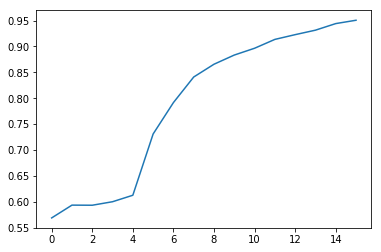

In [19]:
# training model
tensorboard = TensorBoard(log_dir='./logs/{}'.format(int(time.time())), histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min'), tensorboard]

history = model.fit_generator(generator=dataset_generator.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dataset_generator.train_data_frame)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dataset_generator.generator(BATCH, mode='validation'),
                              validation_steps=int(np.ceil(len(dataset_generator.validation_data_frame)/BATCH)))

acc = history.history['acc']
plot(acc)

In [8]:
from keras.models import load_model
model = load_model('anti_spoof_resnet18_2019-06-13_23-25.h5')

Instructions for updating:
Use tf.cast instead.


In [9]:
#%%
# testing model
y_pred_proba = model.predict_generator(dataset_generator.generator(BATCH, mode='test'),
                                       int(np.ceil(len(dataset_generator.test_data_frame)/BATCH)),
                                       verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dataset_generator.test_data_frame['label_id'].values

acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

113/113 [==============================] - 36s 321ms/step
0.9038888888888889


In [21]:
#model.save('anti_spoof_resnet18_2019-06-13_23-25.h5')

In [32]:
len(dataset_generator.wild_test_data_frame)

5000

In [33]:
y_pred_proba = model.predict_generator(dataset_generator.generator(BATCH, mode='wild_test'),
                                       int(np.ceil(len(dataset_generator.wild_test_data_frame)/BATCH)),
                                       verbose=1)

157/157 [==============================] - 50s 316ms/step


In [34]:
wild_test_float_labels = [score[0] for score in y_pred_proba]

In [35]:
wild_test_string_labels = [f'{number:1.8f}' for number in wild_test_float_labels]

In [38]:
len(wild_test_string_labels)

5000

In [44]:
from glob import glob
wild_test_wav_files = glob(os.path.join(TEST_DATA_DIRECTORY + '/wav/', '*.wav'))
wild_test_file_names = []
for file_path in wild_test_wav_files:
    directory_name, full_file_name = os.path.split(file_path)
    wild_test_file_names.append(full_file_name)    
with open('anti_spoof_prediction.txt', 'w') as output_file:
    for file_name, score in zip(wild_test_file_names, wild_test_string_labels):
        output_file.write(f'{file_name}, {score}\n')
    output_file.close

In [42]:
os.path.join(TEST_DATA_DIRECTORY + '/wav/', '*.wav')

'X:\\IDRD\\anti_spoof/data/test/wav/*.wav'